In [1]:
from ema_workbench import load_results
from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, 
                           ema_logging, Constant, Scenario, Policy, CategoricalParameter, IntegerParameter,
                           perform_experiments, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging, utilities
from ema_workbench.analysis import prim
import time

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
#Loading in the base case file
base_case_results=pd.read_csv('base_case_without_NaN.csv')
base_case_results=base_case_results.drop(columns=["Unnamed: 0"])
base_case_results

,A.1_Expected Annual Damage 0,A.1_Dike Investment Costs 0,A.1_Expected Number of Deaths 0,A.2_Expected Annual Damage 0,A.2_Dike Investment Costs 0,A.2_Expected Number of Deaths 0,A.3_Expected Annual Damage 0,A.3_Dike Investment Costs 0,A.3_Expected Number of Deaths 0,A.4_Expected Annual Damage 0,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,4.036285e+06,0,0.004364,4.554415e+07,0,0.062144,0.000000e+00,0,0.000000,0.000000e+00,...,0,0,0,0,0,0,0,15,base case no policy,dikesnet
1,7.620287e+08,0,0.611532,1.492923e+08,0,0.151080,3.023840e+08,0,0.593600,4.911416e+05,...,0,0,0,0,0,0,0,16,base case no policy,dikesnet
2,9.085729e+08,0,0.581077,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.000000e+00,...,0,0,0,0,0,0,0,17,base case no policy,dikesnet
3,9.286149e+07,0,0.048993,7.073281e+07,0,0.048694,4.188630e+06,0,0.005671,1.175439e+06,...,0,0,0,0,0,0,0,18,base case no policy,dikesnet
4,0.000000e+00,0,0.000000,7.091085e+07,0,0.078947,0.000000e+00,0,0.000000,3.294457e+07,...,0,0,0,0,0,0,0,19,base case no policy,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,3.439976e+07,0,0.029896,2.361895e+07,0,0.027094,5.379326e+08,0,1.100780,0.000000e+00,...,0,0,0,0,0,0,0,995,base case no policy,dikesnet
981,4.239234e+07,0,0.029252,1.252469e+07,0,0.011620,2.195979e+07,0,0.038689,1.365650e+07,...,0,0,0,0,0,0,0,996,base case no policy,dikesnet
982,9.373940e+08,0,0.596218,5.252359e+06,0,0.004693,0.000000e+00,0,0.000000,0.000000e+00,...,0,0,0,0,0,0,0,997,base case no policy,dikesnet
983,9.102235e+07,0,0.047832,3.972179e+08,0,0.252305,0.000000e+00,0,0.000000,0.000000e+00,...,0,0,0,0,0,0,0,998,base case no policy,dikesnet


In [4]:
#split base case in outcomes and experiments
outcomes=base_case_results.iloc[:,:51]
experiments=base_case_results.iloc[:,51:]

### Little bit of open exploration
First we want to see how the scenarios are divided according our objectives.
The 5 objectives we want to test are 'Expected Annual Damage of Dike Ring 1', 'Dike Investment Costs of Dike Ring 1', 'Expected Number of Deaths of Dike Ring 1', 'Total Expected Number of Deaths', 'Total Expected Annual Damage'. 
Therefore we will aggregate time and location to see if scenarios score low or high on these objectives.

In [5]:
# Aggregate over time and location to obtain the desired shape of the outcomes
def aggregate_df(df):
    df_aggregate = pd.DataFrame()
    dikerings = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
    timestep = ['0', '1', '2']
    metrics = ['Expected Annual Damage', 'Dike Investment Costs', 'Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']
    
    for metric in metrics:
        if metric == "RfR Total Costs" or metric == "Expected Evacuation Costs":

            columns = [metric + ' ' + time for time in timestep]

            df_aggregate[metric] = df[columns].sum(axis=1)
        else:
            for dikering in dikerings:
                columns = [dikering + '_' + metric + ' ' + time for time in timestep]

                df_aggregate[dikering + '_' + metric] = df[columns].sum(axis=1)
            
            columns_locations = [dikering + '_' + metric for dikering in dikerings]
            df_aggregate['Total ' + metric] = df_aggregate[columns_locations].sum(axis=1)
    
 
    return df_aggregate

In [6]:
#Choosing our objectives as the outcomes
#Dike investment Costs of Dike Ring 1 should be zero since no policies are yet implemented in the basecase
df_aggregate=aggregate_df(outcomes)
outcomes_objectives = ["A.1_Expected Annual Damage","A.1_Dike Investment Costs",\
                        "A.1_Expected Number of Deaths","Total Expected Number of Deaths",\
                        "Total Expected Annual Damage"]
df_aggregate = df_aggregate[outcomes_objectives]
df_aggregate

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,Total Expected Number of Deaths,Total Expected Annual Damage
0,1.513913e+07,0,0.013092,0.199524,1.859643e+08
1,2.148814e+09,0,1.834596,4.069313,3.423863e+09
2,2.725719e+09,0,1.743231,1.800699,2.798736e+09
3,2.573204e+08,0,0.146978,0.317728,4.770971e+08
4,0.000000e+00,0,0.000000,0.288788,3.193655e+08
...,...,...,...,...,...
980,9.700251e+07,0,0.089689,3.473313,1.680499e+09
981,1.038533e+08,0,0.087755,0.278405,2.410400e+08
982,2.487048e+09,0,1.788654,1.996724,2.703948e+09
983,2.278825e+08,0,0.143495,0.900411,1.222352e+09


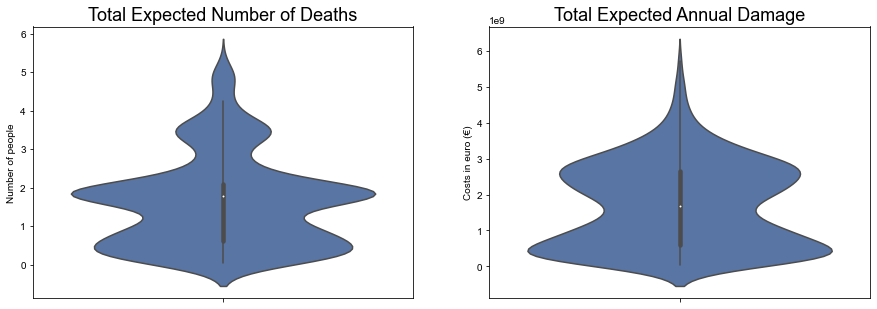

In [7]:
#First we are going to look at the totals

# plotting the number of deaths and the damage costs (aggregated over time and location)
f, axes = plt.subplots(1, 2, figsize=(15,5))
sns.set(style="whitegrid", font_scale=1.5)
plt.rcParams["axes.labelsize"] = 15

sns.violinplot(data=df_aggregate["Total Expected Number of Deaths"], ax=axes[0])
sns.violinplot(data=df_aggregate["Total Expected Annual Damage"], ax=axes[1])

#layout of the plots
axes[0].set_title("Total Expected Number of Deaths")
axes[0].set_ylabel('Number of people')
axes[0].set(xticklabels = [])

axes[1].set_title("Total Expected Annual Damage")
axes[1].set_ylabel('Costs in euro (€)')
axes[1].set(xticklabels = [])

plt.show()

We see that a number of scenarios score low Expected number of Deaths, but there are also a lot of scenarios which score high. Everything above 2 people we consider high.

Looking at total annual damage, we see that there are also some low scoring scenarios but also a lot of high scoring ones. We see that at 2.5e+09 the tip of the violin starts. Let's check which percentages of scenarios score this high.

In [8]:
#Check which percentage of scenarios score high on both objectives.

total= df_aggregate["Total Expected Number of Deaths"].count()
print("Total number of scenarios is", total, "scenarios.")
count_total_death = df_aggregate["Total Expected Number of Deaths"][df_aggregate["Total Expected Number of Deaths"]>2].count()
print(count_total_death, "is", count_total_death/total, "% of", total, "scenarios score higher than 2 people")
count_total_damage = df_aggregate["Total Expected Annual Damage"][df_aggregate["Total Expected Annual Damage"]>2500000000].count()
print(count_total_damage, "is", count_total_damage/total, "% of", total, "scenarios score higher than 2.5e+09 euro's.")

Total number of scenarios is 985 scenarios.
262 is 0.265989847715736 % of 985 scenarios score higher than 2 people
294 is 0.2984771573604061 % of 985 scenarios score higher than 2.5e+09 euro's.




So a lot of scenarios are located in the top 27/30%. Let's check whether this is for each location as well, or if it differs per location.

The number of deaths and annual damage for Dike Ring 1 are also objectives for our case, so that is why we are choosing to dissaggregate over location (and not time).

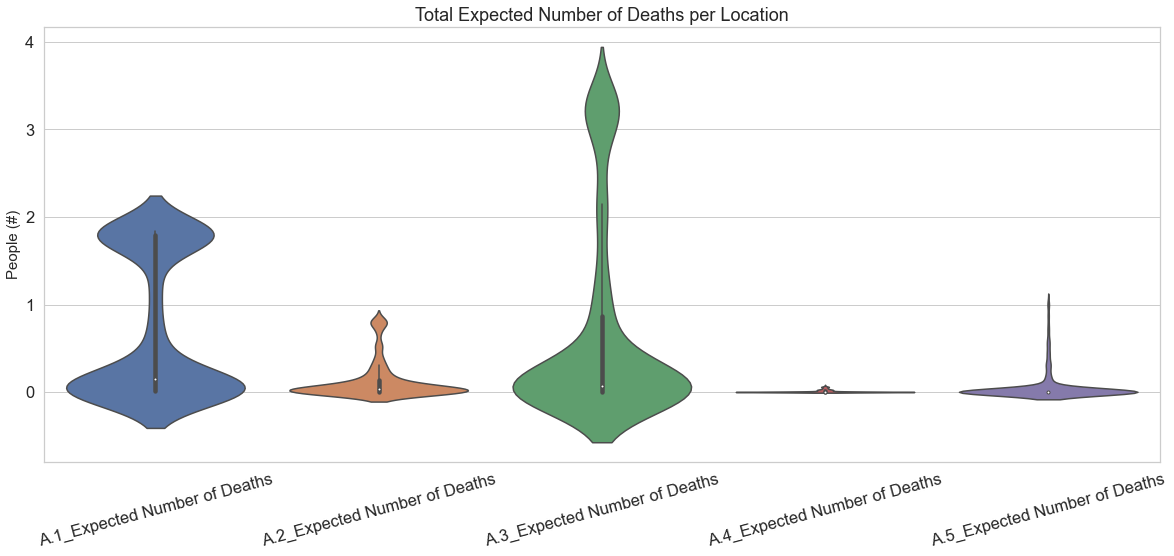

In [9]:
#Secondly, we are looking at the number of death for each location
#aggregated over time
df_location_deaths=aggregate_df(outcomes)
outcomes_of_interest1 = ["A.1_Expected Number of Deaths", "A.2_Expected Number of Deaths","A.3_Expected Number of Deaths", "A.4_Expected Number of Deaths", "A.5_Expected Number of Deaths"]
df_location_deaths = df_location_deaths[outcomes_of_interest1]

f, axes = plt.subplots(1, 1, figsize=(20,8))
sns.set(style="whitegrid", font_scale=1.5)

sns.violinplot(data=df_location_deaths, ax=axes, scale='count')
plt.xticks(rotation=15)
plt.rcParams["axes.labelsize"] = 18

axes.set_title("Total Expected Number of Deaths per Location")
axes.set_ylabel('People (#)')

#plt.savefig("../images/basebase_numberofdeathslocations.png")
plt.show()

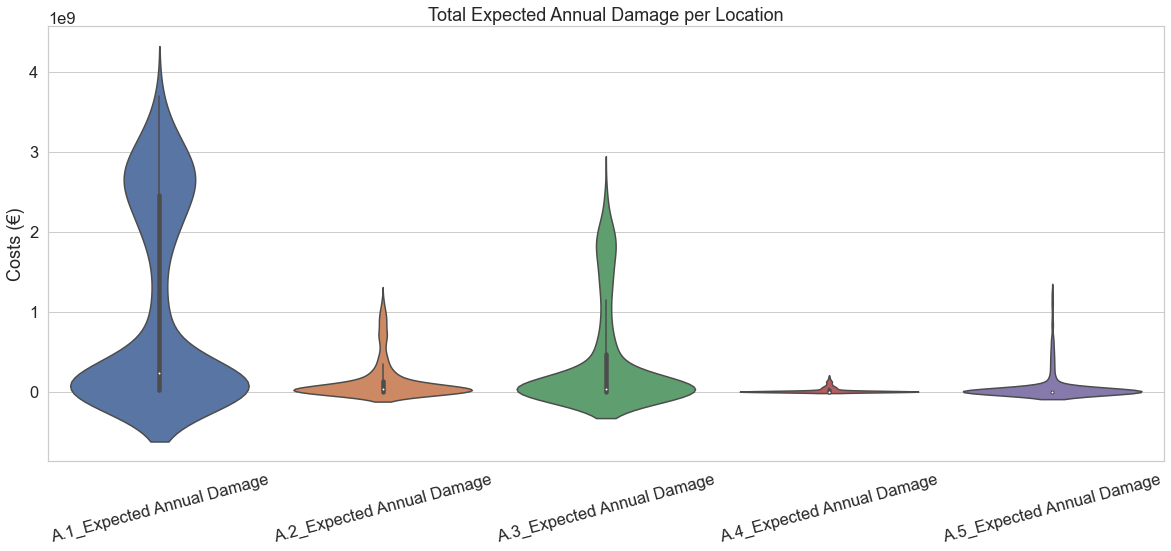

In [10]:
#Thirdly, we are looking at the Annual Damage per location
#aggregated over time

df_location_damage=aggregate_df(outcomes)
outcomes_of_interest2 = ["A.1_Expected Annual Damage", "A.2_Expected Annual Damage","A.3_Expected Annual Damage", "A.4_Expected Annual Damage", "A.5_Expected Annual Damage"]

df_location_damage = df_location_damage[outcomes_of_interest2]

f, axes = plt.subplots(1, 1, figsize=(20,8))
sns.set(style="whitegrid", font_scale=1.5)

sns.violinplot(data=df_location_damage, ax=axes, scale='count')
plt.xticks(rotation=15)
plt.rcParams["axes.labelsize"] = 18

axes.set_title("Total Expected Annual Damage per Location")
axes.set_ylabel('Costs (€)')

#plt.savefig("../images/basebase_annualdamagelocations.png")
plt.show()

We see here that in Dike Ring 1 and Dike Ring 3, there are again a lot scenarios which score high and a lot of scenarios which score low. 

Since 2 of our objectives are number of deaths and expected annual damage for Dike Ring 1, let's check which percentage of scenarios score high.

In [11]:
total_count= df_aggregate["A.1_Expected Number of Deaths"].count()

#We look at figure "Total Expected Number of Deaths per Location"
#We see that in the first violin "A.1_Expected Number of Deaths" the top bulk starts around 1.5
#Therefore we will check which percentage is in the top bulk
count_death = df_aggregate["A.1_Expected Number of Deaths"][df_aggregate["A.1_Expected Number of Deaths"] > 1.5].count()
percentage_death=count_death/total_count

#We look at figure "Total Expected Annual Damage per Location"
#We see that in figure violin "A.1_Expected Annual Damage" the top bulk starts at around 2e+09
#Therefore we will check which percentage is in the top bulk
count_damage = df_aggregate["A.1_Expected Annual Damage"][df_aggregate["A.1_Expected Annual Damage"] > 2000000000].count()
percentage_damage=count_damage/total_count

print("Total amount of scenarios is", total_count)
print("For number of deaths:", count_death, "scenarios score above 1.5 people, which is", percentage_death, "% of total scenarios")
print("For annual damage:", count_damage, "scenarios score above 2e+09, which is", percentage_damage, "% of total scenarios")

Total amount of scenarios is 985
For number of deaths: 347 scenarios score above 1.5 people, which is 0.3522842639593909 % of total scenarios
For annual damage: 325 scenarios score above 2e+09, which is 0.3299492385786802 % of total scenarios


## Establishing the threshold of worst cases

Now that we understand that for A.1_Expected Number of Deaths, A.1_Expected Annual Damage, Total Number of Deaths and Total Annual Damage there are a number of scenarios which score very high. (These are 4 of our 5 objectives, A.1_Dike Investment Costs will not be considered since we are working with the base case, no policies). 

We call the scenarios which exceed the threshold we have established, worst case scenarios.

In [12]:
# Save the value as True or False if the value exceeds the treshold
boolean_threshold = pd.DataFrame()
boolean_threshold["Death_boolean"] = df_aggregate["Total Expected Number of Deaths"] > 2
boolean_threshold["Damage_boolean"] = df_aggregate["Total Expected Annual Damage"] > 2500000000

boolean_threshold["A.1_Death_boolean"] = df_aggregate["A.1_Expected Number of Deaths"] > 1.5
boolean_threshold["A.1_Damage_boolean"] = df_aggregate["A.1_Expected Annual Damage"] > 2000000000

# If both values are above the threshold than set True in worst case boolean series
worst_cases_totals = boolean_threshold["Death_boolean"] & boolean_threshold["Damage_boolean"]
#worst_cases.to_csv('../final assignment/results/boolean_worst_case_scenarios_totals.csv')

worst_cases_A1 =boolean_threshold["A.1_Death_boolean"]&boolean_threshold["A.1_Damage_boolean"]
#worst_cases_A1.to_csv('../final assignment/results/boolean_worst_case_scenarios_A1.csv')

worst_case_scenarios=worst_cases_totals & worst_cases_A1
#worst_case_scenarios.to_csv('../final assignment/results/boolean_worst_scenario_all.csv')

In [13]:
# Since we are not using policies, we can delete all inputs about dike increases, RfR and evacuation time
new_experiments = experiments.iloc[:,:19]
new_experiments.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,19,93.023790,1.5,0.748883,263.404585,10.0,0.273062,176.767531,10.0,0.578308,133.005763,1.0,0.792671,213.412932,10.0,0.949322,4.5,2.5,3.5
1,123,101.422013,1.5,0.138024,210.856574,1.0,0.059383,152.325470,1.0,0.117431,285.872685,1.0,0.077937,292.243986,10.0,0.401123,3.5,4.5,3.5
2,7,304.143707,10.0,0.337110,275.749497,1.5,0.930965,205.923257,1.0,0.466004,71.456906,1.0,0.294562,42.163356,1.0,0.027539,2.5,2.5,2.5
3,43,336.283665,1.5,0.544184,328.636942,1.5,0.346368,199.235476,10.0,0.653444,49.671142,1.5,0.479646,67.694873,1.0,0.324707,1.5,2.5,1.5
4,45,312.289962,1.0,0.978617,211.533047,1.0,0.252732,121.743473,1.0,0.748695,118.751766,10.0,0.128881,285.608062,1.5,0.337620,3.5,2.5,4.5


[MainProcess/INFO] 985 points remaining, containing 120 cases of interest
[MainProcess/INFO] mean: 0.546875, mass: 0.0649746192893401, coverage: 0.2916666666666667, density: 0.546875 restricted_dimensions: 9


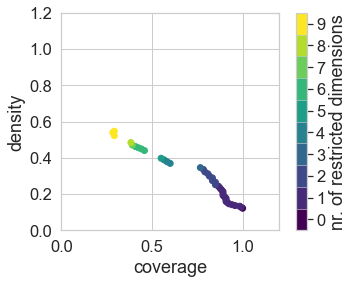

In [14]:
# Execute prim algorithm for the totals objectives
# We select the value for the threshold by trial and error such that we get all the dimensions as output 
prim_alg = prim.Prim(new_experiments, worst_cases_totals, threshold=0.53)
box1 = prim_alg.find_box()

# Show trade off plot
box1.show_tradeoff()
plt.show()

[MainProcess/INFO] 985 points remaining, containing 321 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.21928934010152284, coverage: 0.6728971962616822, density: 1.0 restricted_dimensions: 4


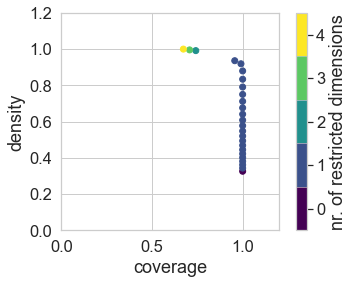

In [15]:
# Execute prim algorithm for the A1 cases
prim_alg = prim.Prim(new_experiments, worst_cases_A1, threshold=0.8)
box1 = prim_alg.find_box()

# Show trade off plot
box1.show_tradeoff()
plt.show()

[MainProcess/INFO] 985 points remaining, containing 83 cases of interest
[MainProcess/INFO] mean: 0.5714285714285714, mass: 0.06395939086294417, coverage: 0.43373493975903615, density: 0.5714285714285714 restricted_dimensions: 11


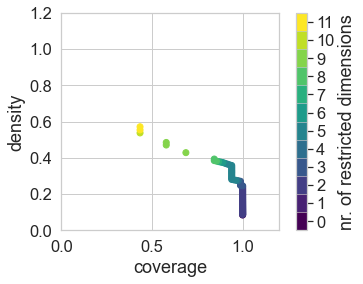

In [16]:
# Execute prim algorithm for the all the cases
prim_alg = prim.Prim(new_experiments, worst_case_scenarios, threshold=0.55, peel_alpha= 0.02)
box1 = prim_alg.find_box()

# Show trade off plot
box1.show_tradeoff()
plt.show()

## Min Max Values

First, we need to assess the min max values under which we can perform MORDM.
This is based on the Notebook file Minimum and maximum values.

In [17]:
experiments2, outcomes2 = load_results('../final assignment/results/policies_fully_disaggregated.tar.gz') 
df2_outcomes = pd.DataFrame.from_dict(outcomes2)

[MainProcess/INFO] results loaded successfully from C:\Users\31649\Documents\Master\Model-based decisionmaking\epa1361_open-master\final assignment\results\policies_fully_disaggregated.tar.gz


In [18]:
#Choosing our objectives as the outcomes
#Dike investment Costs of Dike Ring 1 should be zero since no policies are yet implemented in the basecase
df2_aggregate=aggregate_df(df2_outcomes)
outcomes_objectives = ["A.1_Expected Annual Damage","A.1_Dike Investment Costs",\
                        "A.1_Expected Number of Deaths","Total Expected Number of Deaths",\
                        "Total Expected Annual Damage"]
df2_aggregate = df2_aggregate[outcomes_objectives]
df2_aggregate

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,Total Expected Number of Deaths,Total Expected Annual Damage
0,0.000000e+00,2.006358e+08,0.000000,0.006540,6.640217e+07
1,0.000000e+00,2.006358e+08,0.000000,0.020768,1.431763e+08
2,0.000000e+00,2.006358e+08,0.000000,0.005515,5.264942e+07
3,0.000000e+00,2.006358e+08,0.000000,0.003705,2.574227e+07
4,0.000000e+00,2.006358e+08,0.000000,0.056785,5.248435e+08
...,...,...,...,...,...
39995,0.000000e+00,1.351227e+08,0.000000,0.000276,1.287416e+06
39996,0.000000e+00,1.351227e+08,0.000000,0.000044,3.102785e+05
39997,0.000000e+00,1.351227e+08,0.000000,0.000039,4.155308e+05
39998,6.111999e+08,1.351227e+08,0.087021,0.087021,6.111999e+08


In [19]:
max_nopol = df_aggregate.max()
min_nopol = df_aggregate.min()

max_pol = df2_aggregate.max()
min_pol = df2_aggregate.min()

In [20]:
max_of_range = pd.concat([max_nopol, max_pol], axis=1) #axis = 1 because we want the two options PER objective (instead of everything in one column)
min_of_range = pd.concat([min_nopol, min_pol], axis=1)

max_of_range = max_of_range.max(axis=1) #of both options, we want the highest of each objective
min_of_range = min_of_range.min(axis=1)#of both options, we want the lowest of each objective

In [21]:
max_of_range,min_of_range

(A.1_Expected Annual Damage         3.694513e+09
 A.1_Dike Investment Costs          3.753980e+08
 A.1_Expected Number of Deaths      1.834596e+00
 Total Expected Number of Deaths    5.276779e+00
 Total Expected Annual Damage       5.736794e+09
 dtype: float64,
 A.1_Expected Annual Damage         0.0
 A.1_Dike Investment Costs          0.0
 A.1_Expected Number of Deaths      0.0
 Total Expected Number of Deaths    0.0
 Total Expected Annual Damage       0.0
 dtype: float64)

In [22]:
outcome_ranges=pd.concat([max_of_range, min_of_range], axis=1)
outcome_ranges.rename(columns = {0:'Max_values', 1:'Min_values'}, inplace = True)
outcome_ranges

,Max_values,Min_values
A.1_Expected Annual Damage,3.694513e+09,0.0
A.1_Dike Investment Costs,3.753980e+08,0.0
A.1_Expected Number of Deaths,1.834596e+00,0.0
Total Expected Number of Deaths,5.276779e+00,0.0
Total Expected Annual Damage,5.736794e+09,0.0


In [23]:
outcome_ranges.to_csv("outcome_ranges_fenna.csv")

## Worst case reference scenarios

In this paragraph, we will determine the 10 worst case scenarios of the base case. These worst case scenarios are based on the objectives: "A.1_Expected Annual Damage", "A.1_Dike Investment Costs", "A.1_Expected Number of Deaths", "Total Expected Number of Deaths" and "Total Expected Annual Damage". 

Again, the other objective hasn't outcomes yet, since there are no policies yet implemented.


In [25]:
#The True/False dataframes we have are:
worst_cases_totals
worst_cases_A1
worst_case_scenarios

# Make the dataframe a list
worst_case_list_totals = np.array(worst_cases_totals).squeeze() #using squeeze to remove the brackets
worst_case_list_A1 = np.array(worst_cases_A1).squeeze() #using squeeze to remove the brackets
worst_case_list= np.array(worst_case_scenarios).squeeze() #using squeeze to remove the brackets

In [50]:
# Only work with the experiments and the outcomes that are above the threshold (so the worst cases)
experiments_above_threshold = experiments.loc[worst_case_list]
outcomes_above_threshold = pd.DataFrame({key:value[worst_case_list] for key,value in outcomes.items()})

In [27]:
#aggretate over time, per location
d3_aggregate_exp=aggregate_df(outcomes_above_threshold)

In [28]:
d3_aggregate_exp

,A.1_Expected Annual Damage,A.2_Expected Annual Damage,A.3_Expected Annual Damage,A.4_Expected Annual Damage,A.5_Expected Annual Damage,Total Expected Annual Damage,A.1_Dike Investment Costs,A.2_Dike Investment Costs,A.3_Dike Investment Costs,A.4_Dike Investment Costs,A.5_Dike Investment Costs,Total Dike Investment Costs,A.1_Expected Number of Deaths,A.2_Expected Number of Deaths,A.3_Expected Number of Deaths,A.4_Expected Number of Deaths,A.5_Expected Number of Deaths,Total Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
1,2.148814e+09,4.209833e+08,8.526804e+08,1.384951e+06,0.000000e+00,3.423863e+09,0,0,0,0,0,0,1.834596,0.453239,1.780801,0.000677,0.000000,4.069313,0.0,0.0
13,2.178517e+09,2.621569e+08,0.000000e+00,7.453918e+07,0.000000e+00,2.515213e+09,0,0,0,0,0,0,1.805946,0.293622,0.000000,0.037846,0.000000,2.137414,0.0,0.0
29,3.039581e+09,6.165098e+07,3.887356e+08,0.000000e+00,0.000000e+00,3.489968e+09,0,0,0,0,0,0,1.785498,0.048296,0.575642,0.000000,0.000000,2.409437,0.0,0.0
32,3.191960e+09,0.000000e+00,1.318269e+08,0.000000e+00,1.306337e+08,3.454420e+09,0,0,0,0,0,0,1.798284,0.000000,0.194531,0.000000,0.094681,2.087497,0.0,0.0
36,2.630173e+09,0.000000e+00,1.834592e+09,0.000000e+00,0.000000e+00,4.464765e+09,0,0,0,0,0,0,1.746643,0.000000,3.001216,0.000000,0.000000,4.747858,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,2.172220e+09,0.000000e+00,3.798629e+08,1.938228e+07,0.000000e+00,2.571465e+09,0,0,0,0,0,0,1.799394,0.000000,0.818951,0.010409,0.000000,2.628754,0.0,0.0
966,2.758565e+09,1.609602e+07,1.653567e+08,0.000000e+00,0.000000e+00,2.940018e+09,0,0,0,0,0,0,1.783054,0.015189,0.288660,0.000000,0.000000,2.086902,0.0,0.0
967,2.807891e+09,3.050294e+08,0.000000e+00,3.572173e+06,0.000000e+00,3.116492e+09,0,0,0,0,0,0,1.823200,0.255352,0.000000,0.001391,0.000000,2.079944,0.0,0.0
974,3.063316e+09,0.000000e+00,2.075026e+09,0.000000e+00,0.000000e+00,5.138343e+09,0,0,0,0,0,0,1.803056,0.000000,3.033087,0.000000,0.000000,4.836143,0.0,0.0


In [29]:
#Choosing our objectives as the outcomes
#Dike investment Costs of Dike Ring 1 should be zero since no policies are yet implemented in the basecase
df3=aggregate_df(outcomes_above_threshold)
outcomes_objectives = ["A.1_Expected Annual Damage","A.1_Dike Investment Costs",\
                        "A.1_Expected Number of Deaths","Total Expected Number of Deaths",\
                        "Total Expected Annual Damage"]
df3 = df3[outcomes_objectives]
df3

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,Total Expected Number of Deaths,Total Expected Annual Damage
1,2.148814e+09,0,1.834596,4.069313,3.423863e+09
13,2.178517e+09,0,1.805946,2.137414,2.515213e+09
29,3.039581e+09,0,1.785498,2.409437,3.489968e+09
32,3.191960e+09,0,1.798284,2.087497,3.454420e+09
36,2.630173e+09,0,1.746643,4.747858,4.464765e+09
...,...,...,...,...,...
962,2.172220e+09,0,1.799394,2.628754,2.571465e+09
966,2.758565e+09,0,1.783054,2.086902,2.940018e+09
967,2.807891e+09,0,1.823200,2.079944,3.116492e+09
974,3.063316e+09,0,1.803056,4.836143,5.138343e+09


In [84]:
# We rank each column to find the worst cases of each column
rank_df = pd.DataFrame()
for column in df3.columns:
    rank_df[column] = df3[column].rank()

#To see which scenario is the worst case we have to sum up all the ranking 
rank_df['Sum ranking'] = rank_df.sum(axis=1)

In [85]:
# Then we sort the ranking dataframe to find the 10 worst case scenarios 
worst_10_df = rank_df.sort_values(by='Sum ranking',ascending=False).head(10)

#Find the indexes of those scenarios (keep in mind that this is the index of the aggegrated dataframe of the experiments above the threshold)
worst_10_id = list(worst_10_df.index)
worst_10_id

[389, 519, 541, 335, 974, 52, 382, 815, 569, 479]

In [57]:
#for worst_cases_totals

experiments_above_threshold_2 = experiments.loc[worst_case_list_totals]
outcomes_above_threshold_2 = pd.DataFrame({key:value[worst_case_list_totals] for key,value in outcomes.items()})

#aggretate over time, per location
d3_aggregate_exp2=aggregate_df(outcomes_above_threshold_2)

In [61]:
#Choosing our objectives as the outcomes
#Dike investment Costs of Dike Ring 1 should be zero since no policies are yet implemented in the basecase
totals_df3=aggregate_df(outcomes_above_threshold_2)
outcomes_objectives = ["A.1_Expected Annual Damage","A.1_Dike Investment Costs",\
                        "A.1_Expected Number of Deaths","Total Expected Number of Deaths",\
                        "Total Expected Annual Damage"]
totals_df3 = totals_df3[outcomes_objectives]

In [82]:
rank_df3 = pd.DataFrame()
for column in totals_df3.columns:
    rank_df3[column] = totals_df3[column].rank()

#To see which scenario is the worst case we have to sum up all the ranking 
rank_df3['Sum ranking'] = rank_df3.sum(axis=1)

In [83]:
# Then we sort the ranking dataframe to find the 10 worst case scenarios 
worst_10_df3 = rank_df3.sort_values(by='Sum ranking',ascending=False).head(10)

#Find the indexes of those scenarios (keep in mind that this is the index of the aggegrated dataframe of the experiments above the threshold)
worst_10_id3 = list(worst_10_df3.index)
worst_10_id3

[389, 519, 541, 335, 974, 52, 815, 382, 406, 630]

In [68]:
#find the outcomes of the worst cases
df_scenarios_outcomes=df3.loc[[389, 519, 541, 335, 974, 52, 382, 815, 569, 479]]
df_scenarios_outcomes

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,Total Expected Number of Deaths,Total Expected Annual Damage
389,3.140929e+09,0,1.825323,4.980270,5.349766e+09
519,2.821894e+09,0,1.834596,4.806822,4.683804e+09
541,2.930145e+09,0,1.812074,5.109685,5.112206e+09
335,3.202786e+09,0,1.805946,4.352027,5.012169e+09
974,3.063316e+09,0,1.803056,4.836143,5.138343e+09
52,2.662148e+09,0,1.823493,4.973190,4.492957e+09
382,3.355106e+09,0,1.779386,4.951032,5.720672e+09
815,2.745282e+09,0,1.818492,4.989259,4.695672e+09
569,3.095141e+09,0,1.826584,2.809153,3.868590e+09
479,3.214538e+09,0,1.814265,2.891957,3.956945e+09


In [69]:
# Finally, we want to see to which original scenarios (and therefore uncertainties) these worst cases correspond
#these are the experiments
scenarios_df = experiments_above_threshold.loc[worst_10_id,:]
id_scenarios = scenarios_df.index.to_list()
id_scenarios

[389, 519, 541, 335, 974, 52, 382, 815, 569, 479]

In [70]:
#We only want the first 19 columns of the experiment dataframe (these are the uncertainties)
df_scenarios_experiments=scenarios_df.iloc[:, :19]
df_scenarios_experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
389,112,76.539055,1.5,0.005280,118.386904,1.0,0.359809,209.556219,1.5,0.040066,122.305318,1.5,0.823036,349.115851,1.5,0.015937,2.5,2.5,1.5
519,123,186.582908,1.0,0.124598,341.713134,1.5,0.814515,141.797954,1.0,0.002934,49.084925,10.0,0.504394,74.998111,10.0,0.090257,2.5,4.5,1.5
541,121,44.976172,1.0,0.154180,315.527619,10.0,0.278339,320.949897,1.0,0.028642,126.594441,1.5,0.999996,246.041200,1.0,0.526665,3.5,2.5,1.5
335,127,98.612264,1.5,0.304277,49.174700,1.5,0.582915,76.144141,1.5,0.119453,234.760282,1.0,0.652885,178.009828,1.0,0.789073,3.5,1.5,1.5
974,15,116.453125,1.5,0.330338,191.666985,10.0,0.674579,308.936390,1.5,0.064977,51.506522,1.5,0.499539,211.661021,1.0,0.050274,1.5,1.5,4.5
52,16,56.916820,10.0,0.240521,31.736049,1.0,0.964939,170.723953,10.0,0.044259,38.867025,1.0,0.768002,320.791635,1.0,0.604603,2.5,2.5,3.5
382,21,31.602058,1.5,0.002186,268.091054,1.5,0.872423,209.141531,1.5,0.029959,153.737138,1.0,0.211278,220.093269,1.0,0.359627,1.5,2.5,1.5
815,3,70.802485,1.0,0.225231,194.505227,1.5,0.309677,156.443098,10.0,0.058563,222.688561,1.0,0.052355,157.935464,1.0,0.995289,3.5,3.5,1.5
569,35,110.296335,10.0,0.021863,126.500614,1.0,0.111949,289.881231,1.0,0.183237,109.474479,1.5,0.601160,33.932697,10.0,0.387698,1.5,1.5,4.5
479,58,87.638090,10.0,0.010661,294.140213,1.5,0.822322,173.840848,10.0,0.194060,310.370049,1.5,0.633064,304.619784,1.5,0.469822,3.5,1.5,1.5


In [71]:
# Specify the scenarios in the workbench
scenarios = [Scenario(f"{index}", **row) for index, row in df_scenarios_experiments.iterrows()]

## Execute MORDM for worst case scenarios

In [72]:
outcome_ranges

,Max_values,Min_values
A.1_Expected Annual Damage,3.694513e+09,0.0
A.1_Dike Investment Costs,3.753980e+08,0.0
A.1_Expected Number of Deaths,1.834596e+00,0.0
Total Expected Number of Deaths,5.276779e+00,0.0
Total Expected Annual Damage,5.736794e+09,0.0


In [73]:
outcome_ranges.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, A.1_Expected Annual Damage to Total Expected Annual Damage
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Max_values  5 non-null      float64
 1   Min_values  5 non-null      float64
dtypes: float64(2)
memory usage: 120.0+ bytes


In [74]:
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation
dike_model, planning_steps = get_model_for_problem_formulation(0)

# Build a user-defined scenario and policy:
reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                        'ID flood wave shape': 4, 'planning steps': 2}
reference_values.update({'discount rate {}'.format(n): 3.5 for n in planning_steps})
scen1 = {}

for key in dike_model.uncertainties:
    name_split = key.name.split('_')

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario('reference', **scen1)

In [75]:
from problem_formulation_modified1 import get_model_for_problem_formulation_modified

In [76]:
dike_model,  planning_steps = get_model_for_problem_formulation_modified(outcome_ranges)
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [77]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import load_results
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench import (Model, MultiprocessingEvaluator, SequentialEvaluator,
                           Constraint, Policy, Scenario)

from problem_formulation import get_model_for_problem_formulation

import time


### Code of other group

In [78]:
#Define the values for epsilon
list_epsilons=[]
for column in df2_aggregate.columns:
    new_df = df2_aggregate[df2_aggregate[column] >0]
    epsilon=min(new_df[column])
    list_epsilons.append(epsilon)

In [79]:
list_epsilons

[425513.8617408112,
 82486364.23710208,
 4.8454387049822016e-05,
 3.942122931196812e-06,
 51545.63341453237]

In [80]:
deaths = ['Expected Number of Deaths']

max_num_deaths = 0.0001 * 3 * 5

# Adding the constraint for the allowed maximum number of deaths defined by the Delta Commission. By setting this as a constraint, the optimization will not
# return policies that do not meet this criterion.
constraints = [Constraint("Max number of deaths", outcome_names=deaths,
                          function=lambda x:max(0, x-max_num_deaths))]

In [81]:
ema_logging.log_to_stderr(ema_logging.INFO)

# The Hypervolume space has already been defined in the get_problem_formulation_altered function
convergence_metrics = [HyperVolume.from_outcomes(dike_model.outcomes),
                       EpsilonProgress()]

nfe = 1
results_deep = []
convergence_all = []

for scenario in scenarios:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results_runs, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                        epsilons=list_epsilons,
                                        convergence=convergence_metrics, reference=scenario, constraints=constraints)
                                        
        
        results_deep.append(results_runs)
        convergence_all.append(convergence)
# from ema_workbench import save_results

# for i in range(len(results_deep)):
#     save_results((results_deep[i], convergence_all[i]), f'../results/mordm_7500_rp_scenario{i}.tar.gz')

[MainProcess/INFO] pool started with 8 workers
100it [00:33,  3.02it/s]                                                       
[MainProcess/INFO] optimization completed, found 4 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
100it [00:33,  2.99it/s]                                                       
[MainProcess/INFO] optimization completed, found 3 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
100it [00:33,  2.95it/s]                                                       
[MainProcess/INFO] optimization completed, found 3 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
100it [00:35,  2.84it/s]                                                       
[MainProcess/INFO] optimization completed, found 3 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
100it [00:37,  2.66it/s]                                 

In [71]:
res = {}
for key in results_deep:
    for value in convergence_all:
        res[key] = value
        convergence_all.remove(value)
        break  

TypeError: unhashable type: 'DataFrame'

In [70]:
#Load in the results
case_results = results_deep, convergence_all
save_results(case_results, '../mordm_worst_case_1nfe_scenario_1.tar.gz')
#experiments, outcomes = case_results
#outcomes = pd.DataFrame(outcomes)
#experiments = pd.DataFrame(experiments)

AttributeError: 'list' object has no attribute 'to_csv'

In [67]:
save_results(results_deep, '../mordm_worst_case_1nfe_scenario_1.tar.gz')

ValueError: too many values to unpack (expected 2)

In [56]:
from ema_workbench import save_results

In [66]:
for i in range(len(results_deep)):
    save_results((results_deep[i], convergence_all[i]), '../mordm_worst_case_1nfe_scenario.tar.gz')

KeyError: 'hypervolume'

In [52]:
# We can now load the saved results
from ema_workbench import load_results

results_deep_1 = []
convergence_all_1 = []

for i in range(len(results_deep)):
    result, convergence = load_results('results/test.tar.gz')
    results_deep_1.append(result)
    convergence_all_1.append(convergence)

In [64]:
id_scenarios

[389, 519, 541, 335, 974, 52, 815, 382, 406, 630]

In [ ]:
id_scenarios_test=[389, 519, 541]

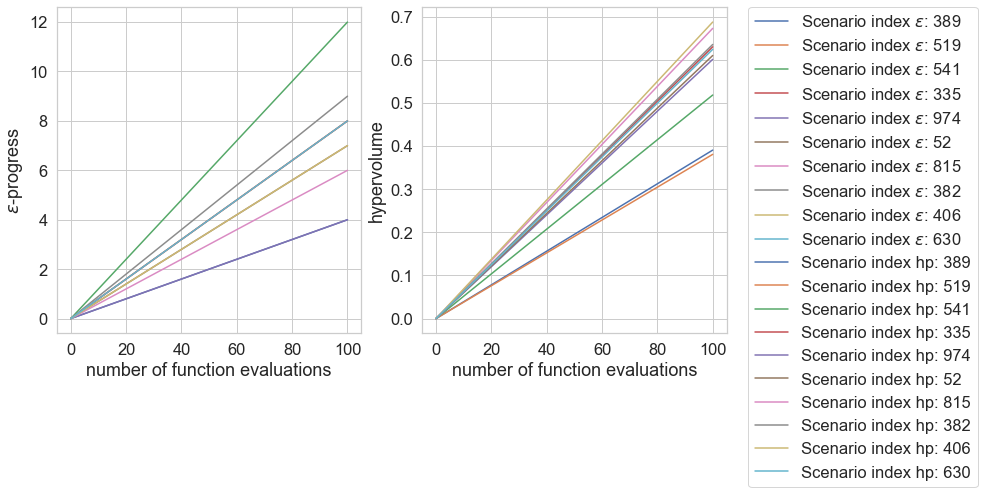

In [65]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(12,6))

for i, con in enumerate(convergence_all):
    ax1.plot(con['nfe'], con['epsilon_progress'], label=f'Scenario index $\epsilon$: {id_scenarios[i]}')
    ax2.plot(con['nfe'], con['hypervolume'], label=f'Scenario index hp: {id_scenarios[i]}')

ax1.set_ylabel('$\epsilon$-progress')
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
fig.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9))
#plt.savefig('../images/MSMORDM_convergence.png')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8, 4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel("$\epsilon$-progress")
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel("hypervolume")

ax1.set_xlabel("number of function evaluations")
ax2.set_xlabel("number of function evaluations")
plt.show()

In [ ]:
from ema_workbench.analysis import parcoords
data = results_runs.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)
#limits.loc[0, list(df_rp.columns)] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [ ]:
ema_logging.log_to_stderr(ema_logging.INFO)

# The Hypervolume space has already been defined in the get_problem_formulation_altered function
convergence_metrics = [HyperVolume.from_outcomes(dike_model.outcomes),
                       EpsilonProgress()]

nfe = 1
results_deep = []
convergence_all = []

for scenario in scenarios:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results_runs, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                        epsilons=[1e7, 1e6, 0.00001],
                                        convergence=convergence_metrics, reference=scenario, constraints=constraints)
                                        
        
        results_deep.append(results_runs)
        convergence_all.append(convergence)
# from ema_workbench import save_results

# for i in range(len(results_deep)):
#     save_results((results_deep[i], convergence_all[i]), f'../results/mordm_7500_rp_scenario{i}.tar.gz')

In [ ]:
results_deep

### Code of Workbench

In [ ]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

robustnes_functions = [
    ScalarOutcome(
        "Total Expected Number of Deaths Min",
        kind=MINIMIZE,
        variable_name="Total Expected Number of Deaths",
    ),
    ScalarOutcome(
        "Total Expected Annual Damage Min",
        kind=MINIMIZE,
        variable_name="Total Expected Annual Damage",
    ),
    # ScalarOutcome(
    #     "10th percentile inertia",
    #     kind=MAXIMIZE,
    #     variable_name="inertia",
    #     function=percentile10,
    # ),
    # ScalarOutcome(
    #     "10th percentile utility",
    #     kind=MAXIMIZE,
    #     variable_name="utility",
    #     function=percentile10,
    # ),
]

In [ ]:
nfe = int(2) #1e6
with SequentialEvaluator(dike_model) as evaluator:
    robust_results = evaluator.robust_optimize(robustnes_functions, df_scenarios_experiments,
                            nfe=nfe, epsilons=[0.05,]*len(robustnes_functions))